In [29]:
from os import getcwd
from os.path import join, abspath

import numpy as np
import pickle
import torch
import torch.nn.functional as F
import torch.optim as optim

from src.data.load_dataset import load_mnist
from src.models.networks import V1_mnist_RFNet, classical_RFNet
from src.models.utils import train, test

In [2]:
data_dir = abspath(join(getcwd(), '../../'))
device = torch.device('cuda' if torch.cuda.is_available else 'cpu') 

In [3]:
# load data
train_batch_size, train_percentage = 1024, 0.999
train_loader, val_loader, test_loader = load_mnist(train_batch_size, train_percentage)
batch_len = len(train_loader)

# training params
scale = 2/784 # since we do a cholesky before generating weights
num_epochs = 10
num_trials = 5
log_interval = 100
loss_fn = F.cross_entropy

# params to iterate over
hidden_size_list = [50, 100, 400, 1000]
lr_list = [1E-1, 1E-2, 1E-3]

## V1 Net

In [ ]:
s, f = 5.32, 1.965
v1_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
v1_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        print(h, lr)
        train_loss = np.zeros((num_trials, len(train_loader) * num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            
            # define the model and optimizer
            model = V1_mnist_RFNet(h, s, f, center=None, scale=scale).to(device)
            model.v1_layer.weight.requires_grad = True
            optimizer = optim.SGD(model.parameters(), lr=lr)
            
            for epoch in range(num_epochs):
                loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=False)
                accuracy = test(model, device, test_loader, verbose=False)
                train_loss[trial, epoch * batch_len:(epoch+1) * batch_len] = loss
                test_accuracy[trial, epoch] = accuracy
            
        # train error
        v1_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        v1_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        v1_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        v1_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

50 0.1
50 0.01
50 0.001
100 0.1
100 0.01
100 0.001
400 0.1
400 0.01
400 0.001
1000 0.1
1000 0.01


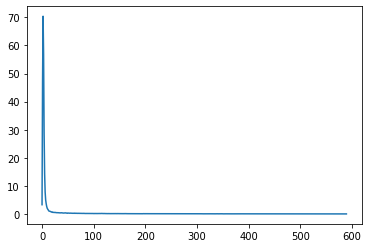

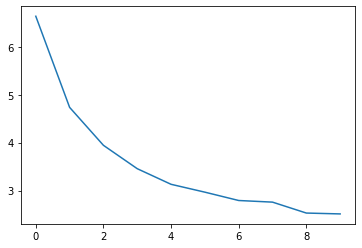

In [17]:
h = 1000
lr = 0.1

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(v1_train_loss[h][lr]['mean'])

fig = plt.figure()
plt.plot(100 - v1_test_accuracy[h][lr]['mean'])

## Classical Net

In [22]:
inp_size = (1, 28, 28)
classical_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
classical_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        print(h, lr)
        train_loss = np.zeros((num_trials, len(train_loader) * num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            
            # define the model and optimizer
            model = classical_RFNet(inp_size, h, scale=scale).to(device)
            model.RF_layer.weight.requires_grad = True
            optimizer = optim.SGD(model.parameters(), lr=lr)
            
            for epoch in range(num_epochs):
                loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=False)
                accuracy = test(model, device, test_loader, verbose=False)
                train_loss[trial, epoch * batch_len:(epoch+1) * batch_len] = loss
                test_accuracy[trial, epoch] = accuracy
            
        # train error
        classical_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        classical_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        classical_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy, axis=0)
        classical_test_accuracy[h][lr]['std'] = np.std(test_accuracy, axis=0) / np.sqrt(num_trials)

50 0.1
50 0.01
50 0.001
100 0.1
100 0.01
100 0.001
400 0.1
400 0.01
400 0.001
1000 0.1
1000 0.01
1000 0.001


## incompatible net

In [24]:
s, f = 0.5, 0.5
incompatible_train_loss = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}
incompatible_test_accuracy = {h: {lr: {'mean': [], 'std': []} for lr in lr_list} for h in hidden_size_list}

for h in hidden_size_list:
    for lr in lr_list:
        print(h, lr)
        train_loss = np.zeros((num_trials, len(train_loader) * num_epochs))
        test_accuracy = np.zeros((num_trials, num_epochs))
        for trial in range(num_trials):
            
            # define the model and optimizer
            model = V1_mnist_RFNet(h, s, f, center=None, scale=scale).to(device)
            model.v1_layer.weight.requires_grad = True
            optimizer = optim.SGD(model.parameters(), lr=lr)
            
            for epoch in range(num_epochs):
                loss = train(log_interval, device, model, train_loader, optimizer, epoch, loss_fn, verbose=False)
                accuracy = test(model, device, test_loader, verbose=False)
                train_loss[trial, epoch * batch_len:(epoch+1) * batch_len] = loss
                test_accuracy[trial, epoch] = accuracy
            
        # train error
        incompatible_train_loss[h][lr]['mean'] = np.mean(train_loss, axis=0)
        incompatible_train_loss[h][lr]['std'] = np.std(train_loss, axis=0) / np.sqrt(num_trials)
        
        # test error
        incompatible_test_accuracy[h][lr]['mean'] = np.mean(test_accuracy)
        incompatible_test_accuracy[h][lr]['std'] = np.std(test_accuracy) / np.sqrt(num_trials)

50 0.1
50 0.01
50 0.001
100 0.1
100 0.01
100 0.001
400 0.1
400 0.01
400 0.001
1000 0.1
1000 0.01
1000 0.001


In [30]:
# save results
results = {}
results['V1'] = {'train_loss': v1_train_loss, 'test_accuracy': v1_test_accuracy}
results['classical'] = {'train_loss': classical_train_loss, 'test_accuracy': classical_test_accuracy}
results['incompatible'] = {'train_loss': incompatible_train_loss, 'test_accuracy': incompatible_test_accuracy}

with open(data_dir + '/models/results/initialize_mnist/full_data/clf_s=%0.2f_f=%0.2f_torch.pickle' % (5.32, 1.965), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

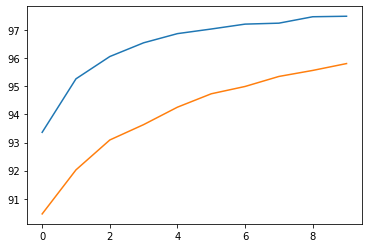

In [42]:
h, lr = 1000, 0.1
fig = plt.figure()
plt.plot(results['V1']['test_accuracy'][h][lr]['mean'])
plt.plot(results['classical']['test_accuracy'][h][lr]['mean'])
# plt.ylim(0, 1)